In [1]:
from qiskit_nature.second_q.drivers import Psi4Driver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

Creating molecular configuration in Psi4Driver format. This configuration represents the positions of molecules' nucleus.

In [2]:
molecule_config = """
molecule h2 {
  0 1
  H 0.0 0.0 0.0
  H 0.0 0.0 0.74
}

set basis sto-3g
"""

Creating instance of driver and problem from qiskit Nature library.

In [3]:
driver = Psi4Driver(config=molecule_config)
problem = driver.run()

Creating hamiltonian of the molecule configuration. This creates hamiltonian by using annihilation and creation operators.

In [4]:
hamiltonian = problem.hamiltonian.second_q_op()

There is different methods which can be used in order to map second quantized hamiltonian into qubits. In this example 3 different mapper instances are used.

In [5]:
mapper_parity = ParityMapper()
mapper_jw = JordanWignerMapper()
mapper_bk = BravyiKitaevMapper()

Finally, a function is created in order to buil ansatz which later used in variational quantum eigensolver. This function can create ansatz with different mapping methods.

In [6]:
def create_ansatz(mapper):
    ansatz = UCCSD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    return ansatz

We can see ansatz by simply using print function.

In [15]:
ansatz = create_ansatz(mapper_parity)
print(ansatz)

     ┌─────────────────────────────┐
q_0: ┤0                            ├
     │                             │
q_1: ┤1                            ├
     │  EvolvedOps(t[0],t[1],t[2]) │
q_2: ┤2                            ├
     │                             │
q_3: ┤3                            ├
     └─────────────────────────────┘


We should use optimizer for our variational quantum eigensolver.

In [16]:
optimizer = SLSQP(maxiter=1000)

Callback function gathers desired parameters.

In [23]:
def callback(num_evals, parameters, mean, std):
    energies.append(mean)

In [24]:
result_energies = []

In [25]:
for mapper in [mapper_parity, mapper_jw, mapper_bk]:
    # Initialize an empty list to store energies during optimization
    energies = []

    # Mapping second quantization operators into qubit operators
    qubit_h = mapper.map(hamiltonian)

    # Creating ansatz for selected mapper
    ansatz = create_ansatz(mapper)

    # Creating an instance of estimator which simulates quantum computer behaviour on local computer
    estimator = Estimator()

    # Set up the VQE algorithm
    vqe = VQE(estimator, ansatz=ansatz, optimizer=optimizer, callback=callback)

    # Run the VQE algorithm with the callback
    result = vqe.compute_minimum_eigenvalue(qubit_h)

    # Appending resulting energies to store
    result_energies.append(energies)

In [26]:
def energy_plotter(result_energies):
    # Visualize the optimization process
    plt.plot(result_energies[0], label='Parity Mapper')
    plt.plot(result_energies[1], label='JW Mapper')
    plt.plot(result_energies[2], label='BK Mapper')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Ground State Energy (Hartrees)')
    plt.title('VQE Optimization Process')
    plt.legend()
    plt.show()

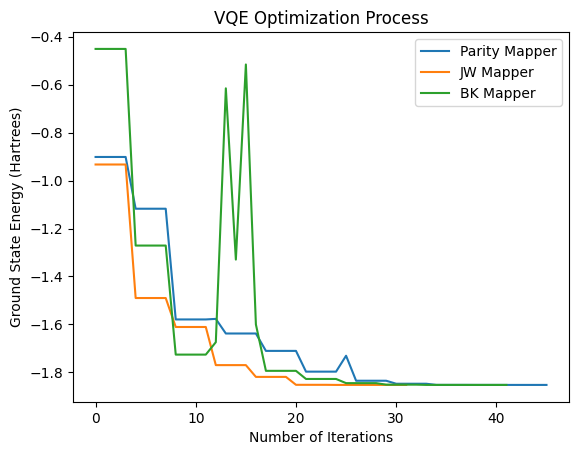

In [27]:
energy_plotter(result_energies)


In the first part the positions of hydrogen atoms in the space was fixed. In order to find minimum energy of the molecule the bond length should be determined. In order to achieve that, the distance between two hydrogen atom is modified and the ground state energy calculated in every step.

In [30]:
distances = np.linspace(0.2, 1.6, 57)

In [31]:
energies = []

In [32]:
for distance in distances:
    # Define the molecule with the updated distance
    molecule_config = "molecule h2 {\n  0 1\n  H  0.0 0.0 0.0\n  H  0.0 0.0 " + str(distance) + "\n}\n\nset {\n  basis sto-3g\n}"

    # Creating an instance of Psi4 Driver using Hydrogen molecule configuration
    driver = Psi4Driver(config=molecule_config)

    # Creating problem
    problem = driver.run()

    # Creating hamiltonian by using second quantization operators
    hamiltonian = problem.hamiltonian.second_q_op()

    # Creating an instances of mapper
    mapper = ParityMapper()

    # Creating ansatz
    ansatz = UCCSD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )

    # Mapping second quantization operators into qubit operators
    qubit_h = mapper.map(hamiltonian)

    # Creating an instance of optimizer
    optimizer = SLSQP(maxiter=1000)

    # Creating an instance of estimator which simulates quantum computer behaviour on local computer
    estimator = Estimator()

    # Set up the VQE algorithm
    vqe = VQE(estimator, ansatz=ansatz, optimizer=optimizer)

    # Computing ground state energy value
    calc = GroundStateEigensolver(mapper, vqe)

    result = calc.solve(problem)

    # Append the result to the list
    energies.append(result.total_energies[0])

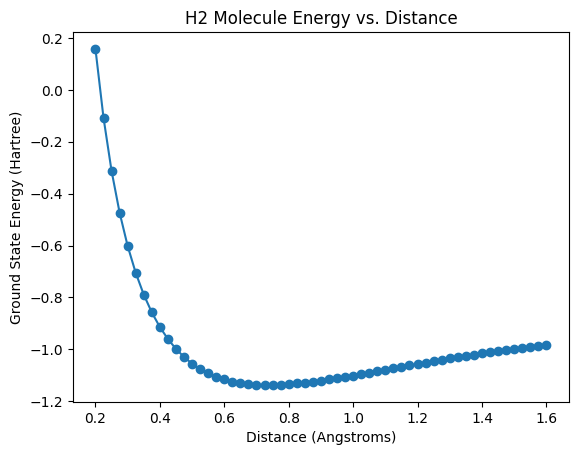

In [33]:
plt.plot(distances, energies, marker='o')
plt.xlabel('Distance (Angstroms)')
plt.ylabel('Ground State Energy (Hartree)')
plt.title('H2 Molecule Energy vs. Distance')
plt.show()